# Assignment 3 - Emergent Communication and Abstractions?

In this assignment we are going to explore the field of Emergent Communication and see how it situates within Cognitive Science as a tool to explain how language is shaped and evolves.

We will first explore how emergent communication works and how two agents can interact with each other to collaboratively solve a task via communicating together. We will then explore how the mechanism of abstractions learning can be used in tandem with emergent communication to obtain results that mimic how humans tend towards concisiveness while playing a collaborative game over repeated interactions.


# Part 1: Emergent Communication (5 points)

Emergent Communication is an area of research within Deep Learning. It studies how populations of agents (in ours and many other cases 2 agents) develop language in order to solve cooperative tasks. Motivations for study in this area include deriving better algorithms for enabling inter-agent cooperation through communication and understanding why human languages have the qualities which they do. This is usually studied within Lewis signalling games, which we will introduce now.

![A Lewis signalling game example.](https://robertodessi.github.io/images/focus.png)

A lewis signalling game is a 2-player cooperative game. The two agents are referred to as the speaker and the listener. The speaker receives an observation (e.g. image, feature vector, etc.) and constructs a message which is communicated to the listener. The listener receives the message and a set of observations. One of these observations is the one that the speaker observed. Using the message and the observation, the listener selects the observation which they think is the best match.

The emergent communication part of this assignment will proceed as follows:
1) Program a Q-learning algorithm which will be used by both the speaker and the listener
2) Train and evaluate the agents on a simple dataset


## Define Q-Learning for Speaker and Listener

In Emergent Communication, our models for both agents are usually neural networks. This is because neural networks allow for great generalization and have a bias for simplicity, making them really helpful at analyzing language evolution. Here instead, to keep things simple, we will use tabular Q-learning for our agents like in Assignment 1. Differently from Assignment 1, we now have 2 (!) agents.

This means we will have 2 Q-tables, one that our first agent (the speaker) will use to choose the word to communicate given the observation, and one that our second agent (the listener) will use to choose what action to pick given the word the speaker communicates to them.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [63]:
"Some useful functions"

def reward_function(actual, guess):
    return int(actual == guess)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def visualise_policies(speaker, listener, num_concepts, preamble = ''):
    if preamble:
        print(preamble)
    for c in range(num_concepts):
        message = speaker.sample_action(c, test=True)
        action = listener.sample_action(message, test=True)
        reward = reward_function(c, action)
        print('Concept: %i, Message: %i, Action: %i, Reward: %i'%(c, message, action, reward))

Instantiate two Q-tables, one for the Speaker and one for the Listener. Make sure that the Speaker maps from concepts to messages and the listener from messages to concepts.

We will start by having 5 concepts and 5 messages, so the Speaker will try to instruct the Listener about 5 different objects. Note that in Emergent Communication usually the episode lasts only one step, so the Q-learning update is simpler than usual (called myopic). The update thus does not involve estimating future rewards. You can achieve that by just simplifying the Q-learning update rule with $\gamma = 0$.

<!-- ![text](algorithm.png) -->
[![Q-learning algorithm](https://miro.medium.com/v2/resize:fit:1400/1*7AWfjw8YDfoRqnIO71DjiA.png)](https://en.wikipedia.org/wiki/Q-learning)

In [49]:
def q_table_speaker(num_concepts, num_messages):
    return np.zeros((num_concepts, num_messages))

def q_table_listener(num_messages, num_concepts):
    return  np.zeros((num_messages, num_concepts))

def epsilon_greedy(Q_listener, message, epsilon=0.1):
    if np.random.rand() < epsilon:
        return np.random.randint(Q_listener.shape[1]) 
    return np.argmax(Q_listener[message])  

# From Assignmnnet 1
def epsilon_decay_exponetial(t):
    return max(0.1, 0.90*0.9999**t) #exponential decay with minimum epsilon = 0.1 and maximum = 0.9



Complete the training loop. Make sure to update both the speaker and the listener. Usually the learning rate is the same but good reasons can be made to do it differently.

100%|███████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [00:06<00:00, 29594.80it/s]


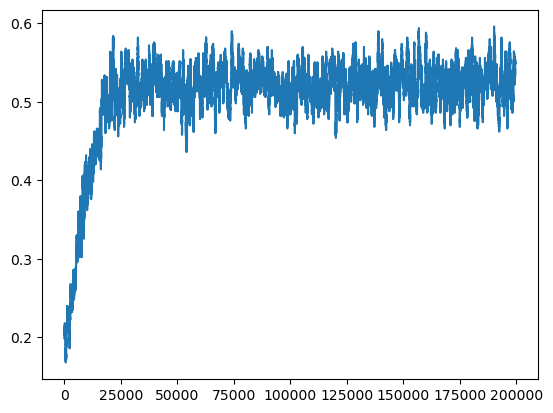

In [58]:
# Param
learning_rate = 0.02

# Speaker
num_concepts = 5
num_messages = 5
n_iterations = 200000

#speaker
speaker = q_table_speaker(num_concepts, num_messages)

# Listener
listener = q_table_listener(num_messages, num_concepts)

# Training
rew_list = []
for epoch in trange(n_iterations):
    concept = np.random.randint(0, num_concepts)
    
    epsilon_speaker = epsilon_decay_exponetial(epoch)
    message = epsilon_greedy(speaker, concept, epsilon_speaker)
    
    epsilon_list = epsilon_decay_exponetial(epoch)
    action = epsilon_greedy(listener, message, epsilon_list)
    reward = reward_function(concept, action)
    
    listener[message, concept] += learning_rate * (reward - listener[message, concept])
    speaker[concept, message] += learning_rate * (reward - speaker[concept, message])
    rew_list.append(reward)


plt.plot(moving_average(rew_list, 500))
plt.show()

Comment here what choices you ended up taking to make communication converge to a good reward:

Your answer: ...

## Part 2: Pancake stacks, a more complex dataset (5 points)

We are going to consider a simplification of the tower-building environment that is presented in McCarthy (https://arxiv.org/pdf/2107.00077). Instead, we are going to consider an agent that creates pancake stacks.

The environment is a simplification of the one of Assignment 1: instead of receiving reward only at the end of the episode, the speaker and listener get rewarded at each step for getting the ingredients right or wrong.

You can imagine it as if the speaker is able to see  at each step what ingredient the listener uses and can tell them if they are doing the right or wrong thing, meanwhile the speaker itself can implicitly reward itself for picking the word that made the listener pick the right action.

In [61]:
import random

class Dataset:

    def __init__(self):
        self.sequences = []

    def add_sequence(self, seq):
        self.sequences.append(seq)

    def get_dataset(self):
        return self.sequences

    def get_average_length(self):
        lengths = [len(s) for s in self.sequences]
        return sum(lengths)/len(lengths)

    def rewrite(self, old_subseq, new_subseq):
        total_reductions = 0
        for seq in self.sequences:
            n = len(old_subseq)
            for i in range(len(seq) - n + 1):
                if seq[i:i+n] == old_subseq:
                    seq[i:i+n] = new_subseq
                    total_reductions += 1
        return total_reductions


def my_dataset():
    recipes = Dataset()
    recipes.add_sequence([0,1,2,0,1,2])
    recipes.add_sequence([0,1,1,0,1,1])
    recipes.add_sequence([0,1,1,0,2])
    recipes.add_sequence([0,2,0,2,0,2])
    recipes.add_sequence([0,1,1,1,1,1])
    recipes.add_sequence([0,2,2,2,2,2])
    recipes.num_ingredients = 3
    return recipes

recipes = my_dataset()

# An example of a rewrite.
#recipes.rewrite([1,1],[3])
#recipes.sequences

def sample_goal(dataset):
     return random.choice(dataset)



First of all, we try a normal communication game where the speaker samples a recipe, and tries to communicate step by step to the listener, who has to recreate the pancake the speaker intended to communicate.

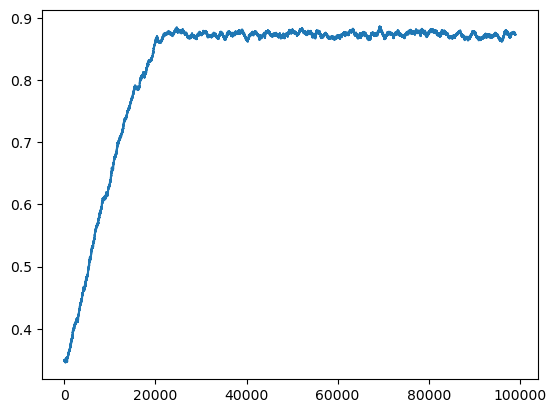

In [84]:
# Param
learning_rate = 0.02

# Dataset
recipes = my_dataset()

# Speaker
num_concepts = 3 # Maximum number of ingredients and abstractions
num_messages = 5 # Maximum number of messages
n_iterations = 100000
speaker = q_table_speaker(num_concepts, num_messages)

# Listener
listener = q_table_speaker(num_messages, num_concepts)

# Training
rew_list = []
dataset = recipes.get_dataset()
#visualise_policies(speaker, listener, num_concepts, preamble='Before training loop')
for epoch in trange(n_iterations):
    goal = sample_goal(dataset) #Sample a recipe from the dataset
    ep_rewards = 0
    for concept in goal:
        epsilon_speaker = epsilon_decay_exponetial(epoch)
        message = epsilon_greedy(speaker, concept, epsilon_speaker)
        
        epsilon_list = epsilon_decay_exponetial(epoch)
        action = epsilon_greedy(listener, message, epsilon_list)
        reward = reward_function(concept, action)
        
        listener[message, concept] += learning_rate * (reward - listener[message, concept])
        speaker[concept, message] += learning_rate * (reward - speaker[concept, message])
        ep_rewards += reward
    rew_list.append(ep_rewards/len(goal))

#visualise_policies(speaker, listener, num_concepts, preamble='After training loop')

plt.plot(moving_average(rew_list, 1000))


Hopefully communication works! If we consider the length of an utterance, here defined as the whole sentence needed to describe a full scene (a goal pancake), you can easily count how long a round of communication is on average.

Your answer:

$\frac{\sum_{goal_i}len(goal_i)}{n_{goals}} = ...$

In the McCarthy paper above, it is shown that humans tend to more concise utterances the more they collaborate on the task. This is achieved through the introduction of abstractions.

In our case an abstraction might look like "a double stack of bacon" or "two bacon stripes with sauce in between". Whatever appears frequently in the dataset is more likely to be "abstracted" into a concept carrying more information!

Thus, we will introduce a mechanism of introducing abstractions in Emergent Communication, to obtain a two-agents system that show the same tendencies as the ones in humans from the McCarthy paper linked above.


We will intertwine the communication with an Abstraction phase, where the Speaker can revise their experience and find the most common subsequence. It can then introduce a new concept (macro-ingredient in our case): an abstraction!

In [83]:
def find_abstractions(dataset):
    "We want to find the most common subsequences in the dataset"
    all_subsequences = {}
    for seq in dataset:
        "Your code: count the frequency of all subsequences of all lengths"
    "Your code: return the most common subsequence, if there are ties, return one of them at random"
    ...
    return ... #e.g. if you find [1,1] to be the most common subsequence, return [1,1]



recipes = my_dataset()
recipes.get_dataset()

[[0, 1, 2, 0, 1, 2],
 [0, 1, 1, 0, 1, 1],
 [0, 1, 1, 0, 2],
 [0, 2, 0, 2, 0, 2],
 [0, 1, 1, 1, 1, 1],
 [0, 2, 2, 2, 2, 2]]

In [85]:
import random

def find_abstractions(dataset):
    "We want to find the most common subsequences in the dataset"
    all_subsequences = {}

    # Iterate through each sequence in the dataset
    for seq in dataset:
        # Iterate over all possible subsequence lengths
        for length in range(1, len(seq) + 1):
            # Iterate through each possible subsequence of the current length
            for i in range(len(seq) - length + 1):
                subseq = tuple(seq[i:i + length])  # Convert subsequence to tuple for hashing
                if subseq in all_subsequences:
                    all_subsequences[subseq] += 1
                else:
                    all_subsequences[subseq] = 1

    # Find the maximum frequency of subsequences
    max_freq = max(all_subsequences.values())

    # Collect all subsequences that have the maximum frequency
    most_common_subsequences = [subseq for subseq, freq in all_subsequences.items() if freq == max_freq]

    # Return one of the most common subsequences at random
    return list(random.choice(most_common_subsequences))

 20%|████████████████████▊                                                                                   | 1/5 [00:11<00:46, 11.68s/it]

Abstraction: (1,), Reductions: 0


 40%|█████████████████████████████████████████▌                                                              | 2/5 [00:20<00:29,  9.74s/it]

Abstraction: (1,), Reductions: 0


 60%|██████████████████████████████████████████████████████████████▍                                         | 3/5 [00:28<00:18,  9.13s/it]

Abstraction: (1,), Reductions: 0


 80%|███████████████████████████████████████████████████████████████████████████████████▏                    | 4/5 [00:36<00:08,  8.80s/it]

Abstraction: (1,), Reductions: 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.01s/it]

Abstraction: (1,), Reductions: 0


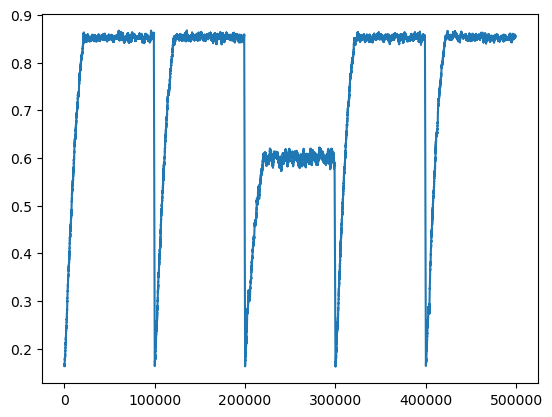

In [87]:
# Param
learning_rate = 0.02

# Dataset
recipes = my_dataset()

# Speaker
"We will use 2 Q-learning agents again"
num_concepts = 8 # Maximum number of ingredients and abstractions (at first, the q-values at the abstraction indexes will not have a meaning but as soon we introduce a new abstraction, one more will)
num_messages = 8 # Maximum number of messages (one per concept we want to communicate)
speaker = q_table_speaker(num_concepts, num_messages)
listener = q_table_listener(num_messages, num_concepts)


"The number of abstractions phases we will do, i.e. how many times we will find an abstraction"
n_abstractions = 5

starting_concepts = recipes.num_ingredients

# Training
rew_list = []
utterance_length_list = []
for step in trange(n_abstractions):
    dataset = recipes.get_dataset()
    utterance_length_list.append(recipes.get_average_length())
    for epoch in range(n_iterations):
        goal = sample_goal(dataset) #Sample a recipe from the dataset
        ep_rewards = 0
        for concept in goal:
            epsilon_speaker = epsilon_decay_exponetial(epoch)
            message = epsilon_greedy(speaker, concept, epsilon_speaker)
            
            epsilon_list = epsilon_decay_exponetial(epoch)
            action = epsilon_greedy(listener, message, epsilon_list)
            reward = reward_function(concept, action)
            
            listener[message, concept] += learning_rate * (reward - listener[message, concept])
            speaker[concept, message] += learning_rate * (reward - speaker[concept, message])
            ep_rewards += reward
        rew_list.append(ep_rewards/len(goal))
    #visualise_policies(speaker, listener, starting_concepts + step, preamble=f'After training loop ({n_abstractions} abstractions)')
    abstraction = find_abstractions(dataset)
    reductions = recipes.rewrite(abstraction, [starting_concepts + step])

    print(f'Abstraction: {abstraction}, Reductions: {reductions}')







plt.plot(moving_average(rew_list, 1000))

Communication should always go back up to 100% correct!

What about utterance length? Does it decrease as it does in humans?

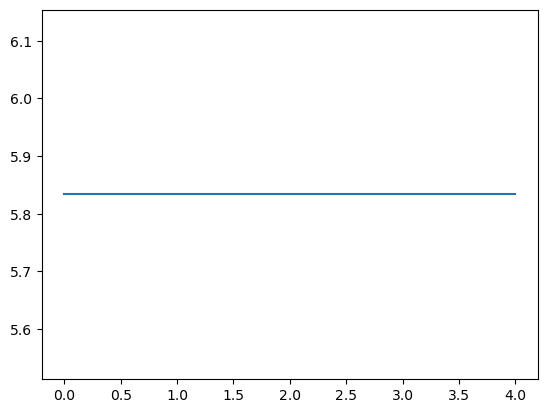

In [80]:
# Plot the average length of the recipes

plt.plot(utterance_length_list)

Hopefully this gave you a simple idea of how Emergent Communication work and why we found that abstractions learning can be used with it to recreate some human tendencies in repeated communication.